# Parallel Computing with Earthdata in the Cloud
## Processing a Large Data Set in Chunks Using a Dask Local Cluster, Example with an SST Seasonal Cycle Analysis

#### *Author: Dean Henze, NASA JPL PO.DAAC*


## Summary


A previous notebook covered the use of Dask and parallel computing applied to the type of tasks in the schematic below, where we have a function which needs to work on a large data set as a whole. This could e.g. because the function works on some or all of the data from each of the files, so we can't just work on each file independently like in the function replication example.

<img src="../../images/basicdask_schematic3.png" alt="sch1" width="500"/>
<img src="../../images/basicdask_schematic2.png" alt="sch1" width="500"/>

In the previous notebook, a toy example was used to demonstrate this basic functionality using a local dask cluster and Xarray built-in functions to work on the data set in chunks. In this notebook, that workflow is expanded to a more complex analysis. The computation is also repeated on several different VM's. 


#### Analysis: Mean Seasonal Cycle of SST Anomalies

The analysis will generate the mean seasonal cycle of sea surface temperature (SST) at each gridpoint in a region of the west coast of the U.S.A. 
The analysis uses a PO.DAAC hosted gridded global SST data sets:
* GHRSST Level 4 MUR Global Foundation SST Analysis, V4.1: 0.01° x 0.01° resolution, global map, daily files, https://doi.org/10.5067/GHGMR-4FJ04

The analysis will use files over the first decade of the time record. The following procedure is used to generate seasonal cycles:

<img src="../../images/schematic_sst-cycle.png" alt="sch_sst-ssh-corr" width="800"/>


In Section 1 of this notebook, the first decade of MUR files are located on PO.DAAC using the `earthaccess` package, then a file is inspected and memory requirements for this data set are assessed. In Section 2, a "medium-sized" computation is performed, deriving the mean seasonal cycle for the files thinned out to once per week (570 files, 1.3 TB of uncompressed data) for about \\$0.10. In Section 3, we perform the computation on all the files in the first decade, ~4000 files, ~10 TB of uncompressed data, for about \\$3.


## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook
* **Earthdata login account:** An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. 
* **Compute environment:** This notebook can technically be run either in the cloud (AWS instance running in us-west-2), or on a local compute environment (e.g. laptop, server). However, running in the cloud is recommended, since it is unlikely that a laptop has the power to replicate the compute times we quote here. If running in a local environment, the number of workers spun up Section 4 will likely need to be decreased.
* **VM type:** For running in AWS (recommended), we used general purpose VM types for Sections 1 and 2, then switched to memory-optimized VM's for the large computations of Section 3 (more on this later). Since the cost per hour of these instances go up in size, we recommend the following workflow to explore this notebook.
> 1. Start by running Section 1 in a lower cost m6i.xlarge instance (fractions of a $1 per hour).
> 2. Section 2 includes the "medium-sized" parallel computations. For this, we ran Sections 1 and 2 on a `m7g.8xlarge` instance. At the time this notebook was written, this VM type took ~2-3 minutes to run the computations, and cost ~\\$1.3/hr.
> 3. For Optional Section 3, we ran using several memory optimized instances, including `r7a.32xlarge`, `r7i.48xlarge`, `r7iz.16xlarge` VMs.


#### Prerequisite knowledge
* The [notebook on Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) and all prerequisites therein.

#### Learning outcomes
This notebook demonstrates how to use Dask with a local cluster to analyze a large data set in chunks, naturally parallelizing Xarray built in functions on the cluster. You will get better insight on how to apply this workflow to your own analysis.

## Import packages

We ran this notebook in a Python 3.12.3 environment. The minimal working install we used to run this notebook from a clean environment was:

*With pip:*

```
pip install xarray==2024.1.0 numpy==1.26.3 h5netcdf==1.3.0 "dask[complete]"==2024.5.2 earthaccess==0.9.0 matplotlib==3.8.0 coiled==1.28.0 jupyterlab jupyter-server-proxy
```

*or with conda:*

```
conda install -c conda-forge xarray==2024.1.0 numpy==1.26.3 h5netcdf==1.3.0 dask==2024.5.2 earthaccess==0.9.0 matplotlib==3.8.0 coiled==1.28.0 jupyterlab jupyter-server-proxy
```

In [1]:
# NASA data access packages:
import earthaccess

# Analysis packages:
import xarray as xr
import numpy as np                 

# Visualization packages:
import matplotlib.pyplot as plt
%matplotlib inline

# Cloud computing / dask packages:
from dask.distributed import Client
import multiprocessing

In [2]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Locate MUR SST file access endpoints for first decade of record, inspect a file
We use `earthaccess` to find metadata and endpoints for the files.

In [3]:
earthaccess.login() # Login with your credentials

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [4]:
datainfo = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    cloud_hosted=True,
    temporal=("2002-01-01", "2013-05-01"),
    )

Granules found: 3988


#### **Open and inspect a file**
Open a file and plot the SST data in the region for our analysis.

In [5]:
fileobj_test = earthaccess.open([datainfo[0]])[0] # Generate file objects from the endpoints which are compatible with Xarray
sst_test = xr.open_dataset(fileobj_test)['analysed_sst']
sst_test

Opening 1 granules, approx size: 0.32 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
[647964000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

In [6]:
# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

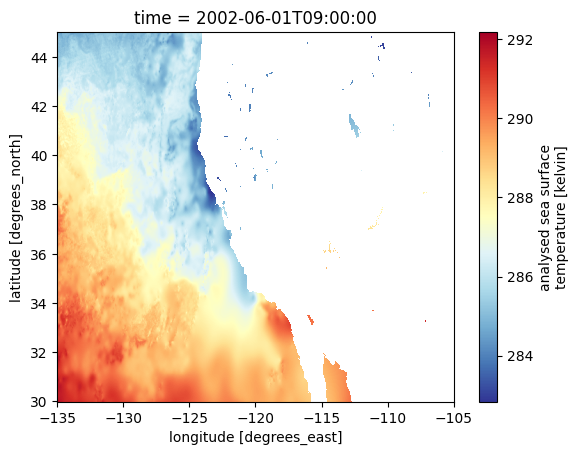

In [7]:
## Plot SST in analysis region:
fig = plt.figure()
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(cmap='RdYlBu_r')

#### **Memory considerations**
Demonstrating that these are fairly large files, especially uncompressed, at the time this notebook was written:

In [8]:
print("Disk size of one file =", datainfo[0]['size'], "MB.")

Disk size of one file = 332.3598403930664 MB.


In [9]:
print("Size in-memory of the SST variable once uncompressed =", sst_test.nbytes/10**9, "GB.")

Size in-memory of the SST variable once uncompressed = 2.591856 GB.


*At ~2.5 GB uncompressed, and ~4000 MUR files at the time this notebook was written, we are dealing with a ~10 TB data set.*

## 2. Seasonal cycle at weekly temporal resolution
*Section 1 needs to be run prior to this*

For this "medium-sized" computation, the decade time record is thinned out to one file per week. This will be ~200 GB on disk, and ~1.3 TB uncompressed in memory. Using the parallel computing methods below, we were able to accomplish this in about 3 minutes for \\$0.10 (1 minute for opening the data set and 2 minutes for computations). For the size of this computation, we obtained good results with an `m7g.8xlarge` instance (32 CPUs, 128 GiB Memory), using 16 workers. 16 workers, rather than the maximum amount of 32, were chosen so that each worker has more memory available (8 GiB rather than 4 GiB).

In [10]:
# Thin to weekly temporal resolution:
datainfo_thinned = [datainfo[i] for i in range(len(datainfo)) if i%7==0]

# Confirm we have about a decade of files at weekly resolution:
print("First and last file times \n--------------------------")
print(datainfo_thinned[0]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print(datainfo_thinned[-1]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print("\nFirst and second file times \n--------------------------")
print(datainfo_thinned[0]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print(datainfo_thinned[1]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])

First and last file times 
--------------------------
2002-05-31T21:00:00.000Z
2013-04-26T21:00:00.000Z

First and second file times 
--------------------------
2002-05-31T21:00:00.000Z
2002-06-07T21:00:00.000Z


Since Xarray built-in functions are used to both open and process the data, the workflow is to start up a cluster, open the files into a single dataset with chunking, and then Xarray function calls will naturally be run in parallel on the cluster.

In [11]:
fileobjs = earthaccess.open(datainfo_thinned) # Generate file objects from the endpoints which are compatible with Xarray

Opening 570 granules, approx size: 190.08 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/570 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/570 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/570 [00:00<?, ?it/s]

In [12]:
## Double check the number of CPU's available on this VM type:
print(multiprocessing.cpu_count())

32


In [13]:
## Local Dask Cluster
client = Client(n_workers=16, threads_per_worker=1)
print(client.cluster)
client.dashboard_link

LocalCluster(07e4762f, 'tcp://127.0.0.1:38783', workers=16, threads=16, memory=122.12 GiB)


'https://cluster-dlufo.dask.host/jupyter/proxy/8787/status'

In [14]:
%%time

## Load files and rechunk SST data:
murdata = xr.open_mfdataset(fileobjs[:], parallel=True, chunks={})
sst = murdata["analysed_sst"]
    # Rechunk to get bigger slices along time dimension, since many of the computations
    # operate along that axis:
sst = sst.chunk(chunks={'lat': 500, 'lon': 500, 'time': 200})
sst

CPU times: user 18 s, sys: 2.16 s, total: 20.2 s
Wall time: 59.5 s


<xarray.DataArray 'analysed_sst' (time: 570, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(570, 17999, 36000), dtype=float32, chunksize=(200, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2013-04-27T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

**Computations**

*We chose not to suppress the large chunk and task graph warnings for the next two blocks:*

In [15]:
## ----------------
## Set up analysis
## ----------------
## (Since these are dask arrays, functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

/opt/coiled/env/lib/python3.12/site-packages/xarray/core/dataset.py:5196: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})


In [16]:
%%time
## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()
#cluster.scale(1)

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 32.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 52.5 s, sys: 7.15 s, total: 59.6 s
Wall time: 2min 12s


#### **Plot results**

In [17]:
# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

Text(0, 0.5, '$\\Delta$T (K)')

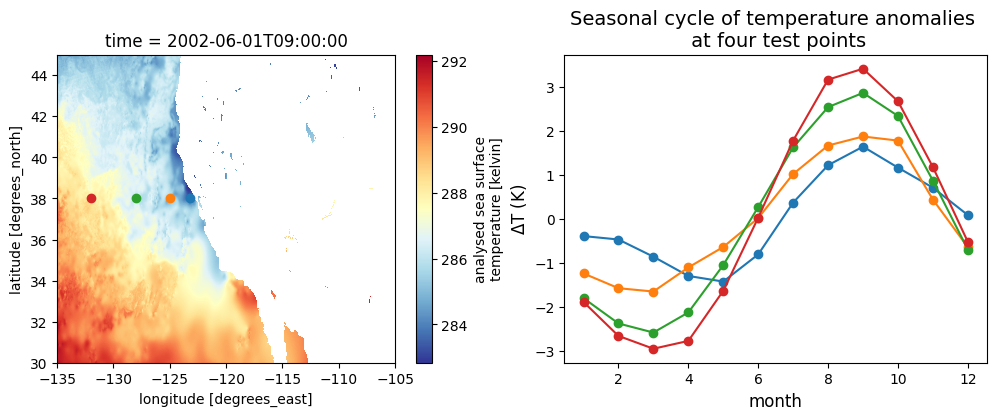

In [18]:
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

## Replot the map and points from the test file:
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(ax=axes2[0], cmap='RdYlBu_r')
for lat, lon in zip(lat_points, lon_points):
    axes2[0].scatter(lon, lat)

## Seasonal cycles on another plot
for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    axes2[1].plot(scycle_point['month'], scycle_point.values, 'o-')

axes2[1].set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
axes2[1].set_xlabel("month", fontsize=12)
axes2[1].set_ylabel(r"$\Delta$T (K)", fontsize=12)

## 3. Seasonal cycle for full record (daily resolution)

*Section 1 needs to be run prior to this, but Section 2 can be skipped.*

In this section, all files in the decade are processed. This will be ~4000 files, ~1.3 TB on disk, and ~10 TB for the SST varaible once uncompressed in memory. We were able to accomplish this using a few different VM's and configurations listed below. *Currently, the code is setup for using a `r7a.32xlarge` VM with 32 workers, which completed the computations in 14 minutes for \\$3 (6 minutes for opening the data set and 8 minutes for computations).*

**More on the VM type chosen**

For this computation, [memory-optimized VMs](https://aws.amazon.com/ec2/instance-types/) were chosen (they have high memory per CPU). This [Coiled post](https://docs.coiled.io/blog/coiled-xarray.html) was used as inspiration, where it is found that having larger chunks are more efficient, which is why memory-optimized VMs are needed to handle the larger chunks. Additionally, we found that having 32 GB per worker, regardless of the worker number, was necessary to complete the computations without receiving memory errors.

**VM runs that worked**
* `r7a.32xlarge` (128 CPUs, 1024 GiB memory): 32 workers each with 32 GB of memory; completed in 13 minutes for \\$3
* `r7i.48xlarge` (192 CPUs, 1,536 GiB memory): 48 workers each with 32 GB of memory; completed in 13 minutes for \\$4
* `r7iz.16xlarge` (64 CPUs, 512 GiB memory): 16 workers each with 32 GB of memory; completed in 18 minutes for \\$2.50

In [10]:
fileobjs = earthaccess.open(datainfo) # Generate file objects from the endpoints which are compatible with Xarray

Opening 3988 granules, approx size: 1330.13 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/3988 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3988 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3988 [00:00<?, ?it/s]

In [11]:
## Double check the number of CPU's available on this VM type:
print(multiprocessing.cpu_count())

128


In [12]:
## Local Dask Cluster
client = Client(n_workers=32, threads_per_worker=1)
print(client.cluster)
client.dashboard_link

LocalCluster(3cd02cc8, 'tcp://127.0.0.1:44455', workers=32, threads=32, memory=0.96 TiB)


'https://cluster-srigu.dask.host/jupyter/proxy/8787/status'

In [13]:
%%time

## Load files and rechunk SST data:
murdata = xr.open_mfdataset(fileobjs, parallel=True, chunks={})
sst = murdata["analysed_sst"]
    # Rechunk to get bigger slices along time dimension, since many of our computations are
    # operating along that axis:
sst = sst.chunk(chunks={'lat': 500, 'lon': 500, 'time': 400})
sst

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 17.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 9s, sys: 29.5 s, total: 2min 38s
Wall time: 5min 31s


<xarray.DataArray 'analysed_sst' (time: 3988, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(3988, 17999, 36000), dtype=float32, chunksize=(400, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2013-05-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

**Computations**

*We chose not to suppress the large chunk and task graph warnings for the next two blocks:*

In [14]:
## ----------------
## Set up analysis
## ----------------
## (Since we're dealing with dask arrays, these functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

/opt/coiled/env/lib/python3.12/site-packages/xarray/core/dataset.py:5196: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})


In [15]:
%%time
## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()

/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 227.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3min 41s, sys: 45.5 s, total: 4min 27s
Wall time: 8min 24s


#### **Plot results**

Text(0, 0.5, '$\\Delta$T (K)')

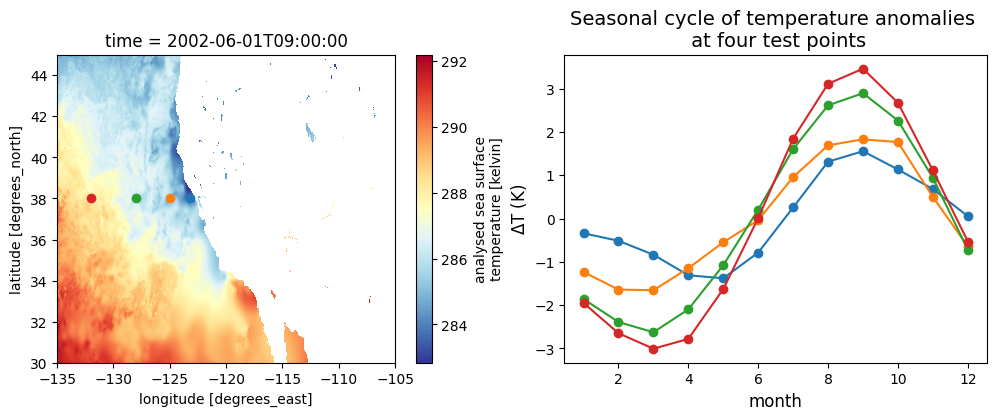

In [16]:
# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

## Replot the map and points from the test file:
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(ax=axes2[0], cmap='RdYlBu_r')
for lat, lon in zip(lat_points, lon_points):
    axes2[0].scatter(lon, lat)

## Seasonal cycles on another plot
for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    axes2[1].plot(scycle_point['month'], scycle_point.values, 'o-')

axes2[1].set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
axes2[1].set_xlabel("month", fontsize=12)
axes2[1].set_ylabel(r"$\Delta$T (K)", fontsize=12)

## 4. Additional Notes
* To compute the mean seasonal cycle, Xarray's built in `groupby()` function is used to group the data by month of the year. As per this [Xarray docs page](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips), one can try using the [flox package](https://flox.readthedocs.io/en/latest/) to speed up this groupby operation.